# I want to explore the Prophet package for forecasting. 
Underneath the hood this procedure uses Additive Regression.
There are four components: 
a piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.

A yearly seasonal component is modeled using Fourier series.

A weekly seasonal component using dummy variables.

(Source: https://peerj.com/preprints/3190.pdf) 

Users can define a list of holidays, modeling future uncertainty with seasonality or holiday effects, we can run a few hundred Hamiltonian Monte Carlo iterations, to include this seasonal uncertainty estimates. 


The model uses the Stan probabilistic programming language. Stan performs the MAP (maximum a posteriori) optimization for parameters (recommended) or Hamiltonian Monte Carlo (not recommended due to poor convergence -Mark Conrad). 


In [157]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import os # directory traversal


In [158]:
!ls
# MUST NOTE THAT MY FILES ARE FAIRLY DISORGANIZED!


PCAR.csv              Prophet_Forecast.jpeg bayes_data.csv
PCAR_five_years.csv   UGA.csv               max_years.csv


In [159]:
df = pd.read_csv("PCAR.csv", encoding='utf-8')


In [160]:

# Prophet requires columns with the name ds (x) and y:
df['ds'] = pd.to_datetime(df['Date'])
# We care about the closing price for PCAR's stock.
df['y'] = df['Adj Close']

In [161]:
df["orig_y"] = df['y']
df["y"] = (df["y"]) 
# # taking the log reduces the outcome space to the exponent of e to get the original number.


In [162]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ds,y,orig_y
0,2012-12-13,44.630001,44.810001,43.840000,43.900002,37.961784,2048300,2012-12-13,37.961784,37.961784
1,2012-12-14,44.009998,44.450001,43.860001,43.910000,37.970425,1974800,2012-12-14,37.970425,37.970425
2,2012-12-17,44.169998,44.349998,43.840000,44.310001,38.316319,1964300,2012-12-17,38.316319,38.316319
3,2012-12-18,44.450001,45.000000,44.290001,44.980000,38.895683,2025300,2012-12-18,38.895683,38.895683
4,2012-12-19,44.900002,45.439999,44.669998,44.939999,38.861092,2348600,2012-12-19,38.861092,38.861092


In [163]:
# df = df.rename(columns = {"date 30 min":"ds", "lst trd /lst prce":'y'})
df["ds"] = pd.DatetimeIndex(df["ds"])
# ax = df.set_index('ds').plot(df['ds'],df['y'])
df['y'] = df['Adj Close']

In [164]:
type(df["ds"][1])

pandas._libs.tslib.Timestamp

By default Prophet only returns uncertainty in the trend and observation noise. To get uncertainty in seasonality, we must do full Bayesian sampling as noted in the Facebook documentation. This process replaces the typical MAP with Markov Chain Monte Carlo (MCMC).

### Important background information
MAP stands for Maximum a posteriori estimation: in Bayesian statistics, a MAP estimate is an estimate of an unknown quantity that equals the mode of the posterior distribution. This gives us a point estimate of an unobserved quantity based on observed empirical data. 

MAP is related to maximum likelihood (ML) estimation which is a special case of MAP that is defined as a process of estimating the parameters of a statistical model given observations, essentially finding the parameter values that maximize the likelihood of making the observations given the parameters, maxmizing the agreement between a set of observations and the selected model (Source: Wikipedia). 

MAP differs in that it employs an augmented optimization objective incorporating a prior distribution incorporating additional information available through prior knowledge of a related event. We can simplify this definition as employing ML estimation with regularization (Source: Wikipedia).

MCMC employs a full sampling and we will then see the uncertainty in seasonal components, which is great, however, it is much slower than the MAP estimation algorithm (especially on Windows using Python). For best results use R on Windows and Python on Unix based operating system.  

In [176]:
# We initialize our Prophet model, mcmc method can be used to generate its forecasts. MCMC is 
# a stochastic process giving us uncertainty intervals in our subplots.
# HMC is awesome Stan's implementation from Gelman's team is really intriguing but we will use the default!
# The default MAP estimation is quicker and tends to converge.
my_model = Prophet( interval_width=0.95)# Prophet(interval_width=.95, uncertainty_samples=10000)

In [178]:
# my_model.fit(df)
forecast = Prophet(interval_width=0.95).fit(df).predict(future)


In [167]:
# future = my_model.make_future_dataframe(periods = 365)
# forecast = my_model.predict(future)

In [168]:
# We use matplotlib.pyplot for matplot-like plotting.
import matplotlib.pyplot as plt

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

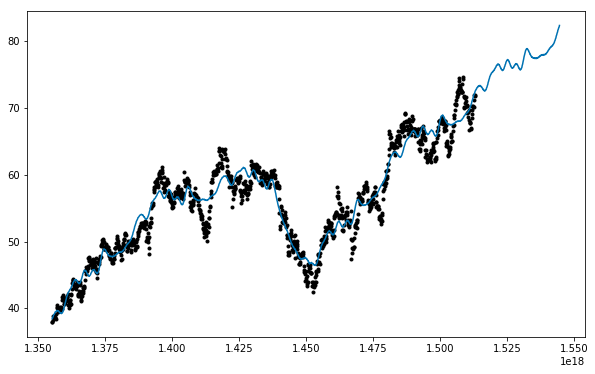

In [188]:
my_model.plot(forecast, uncertainty=True)
# Some error with my confidence interval, still gives a point estimate. 

In [182]:
forecast.describe()


,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
count,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000
mean,0.635608,60.431880,-0.009646,-0.009646,59.150333,61.713242,55.543599,65.331176,-0.004780,-0.004780,-0.004780,-0.004866,-0.004866,-0.004866,-0.009646,60.422234
std,0.357827,11.144204,1.211581,1.211581,9.317702,13.470666,9.969937,12.418367,0.030607,0.030607,0.030607,1.211178,1.211178,1.211178,1.211581,11.039881
min,0.000000,37.684328,-1.982942,-1.982942,37.684328,37.684328,34.172140,42.729507,-0.036558,-0.036558,-0.036558,-1.946566,-1.946566,-1.946566,-1.982942,38.451964
25%,0.323973,52.249569,-1.261543,-1.261543,52.249569,52.249569,48.111747,56.422378,-0.034880,-0.034880,-0.034880,-1.256783,-1.256783,-1.256783,-1.261543,52.295054
50%,0.646849,58.609130,0.034108,0.034108,58.609130,58.609130,53.962266,62.288852,-0.017021,-0.017021,-0.017021,0.042704,0.042704,0.042704,0.034108,58.056869
75%,0.967534,70.081586,1.006039,1.006039,68.841451,70.081586,64.551695,72.829501,0.016656,0.016656,0.016656,1.009065,1.009065,1.009065,1.006039,68.728621
max,1.200000,81.614089,2.205096,2.205096,72.468964,96.031459,72.386650,97.305135,0.045662,0.045662,0.045662,2.160222,2.160222,2.160222,2.205096,82.331042



Prophet uses baked in l1 regularization. It has a large number of potential change points, at which the rate is allowed to change. It then puts a sparse prior (l1 regularization). Essentially Prophet will set a large number of change points and only use a subset of them. 

By default Prophet fits weekly and yearly seasonalities, it can even fit sub-daily time series. The model updates it's priors with new information, the default prior scaling is 10 which provides very little regularization. 

There are three sources of uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise. The biggest source of uncertainty in the forecast is the potential for future trend changes. The model can effectively fit the trend changes, but how do we predict trends in the future? We can assume it will be similar to the past, in that we assume that the average frequency and magnitude of trend changes in the future will be the same as in the past. 
This assumption probably will not hold, thus the coverage of the confidence interval may not be entirely accurate.



Like all models, Prophet is useful but still wrong, it is a simplifying assumption to only use time as a regressor, this is probably best used in concert with other models for prediction such as LSTM or GRU given you have a more complicated input space to which they can find mappings to. 